# Blood Cell Classification using Attention-Enhanced CNN (AE-CNN)
This notebook demonstrates training a convolutional neural network with channel-wise attention (Squeeze-and-Excitation block) for classifying blood cell images from the BloodMNIST dataset.


Margarita Shnaider, Arina Ponomareva



## 1. Environment Setup and Imports
This section includes mounting Google Drive, installing required packages, and importing essential libraries.


In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
cd '/content/drive/MyDrive'

/content/drive/MyDrive


In [3]:
%pip install medmnist
#%pip install tensorflow

In [16]:
%pip install tensorflow==2.17.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 104.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 107.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import zipfile
import tqdm
from tqdm import tqdm
import itertools

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

from scipy.io import loadmat
from scipy.stats import bernoulli

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc, accuracy_score, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight


# Dataset
from medmnist import BloodMNIST

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['axes.grid'] = True
mpl.rcParams['legend.fontsize'] = 'large'

%reload_ext autoreload
%autoreload 2

In [5]:
import tensorflow as tf

print("TensorFlow Version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))


TensorFlow Version: 2.17.0
GPU Available: []


## 2. Dataset Loading and Preprocessing
The dataset used in this project is **BloodMNIST**, part of the [MedMNIST v2](https://medmnist.com/) collection. BloodMNIST consists of 17,092 color images of blood cells, each annotated into one of **eight** distinct classes. The task is a **multi-class classification** problem with uneven class distribution.

Each image is a cropped sample of an individual cell, provided as an RGB image in PIL format. Originally, images are 28×28 in size, but for the AE-CNN model we resize all inputs to 64×64 pixels to better leverage convolutional feature extraction. All pixel values are normalized to the \([0,1]\) range.

The dataset is split using the predefined MedMNIST partitions:
- **70% Training** (11,959 images)
- **15% Validation** (1,712 images)
- **15% Test** (3,421 images)

For training stability and performance comparison, labels are kept as integer class indices (0 to 7), and no further encoding is performed at this stage.


### Load and split dataset

In [5]:
train_dataset = BloodMNIST(split="train", download=True, transform=None)
val_dataset = BloodMNIST(split="val", download=True, transform=None)
test_dataset = BloodMNIST(split="test", download=True, transform=None)

In [7]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Train dataset size: 11959
Validation dataset size: 1712
Test dataset size: 3421


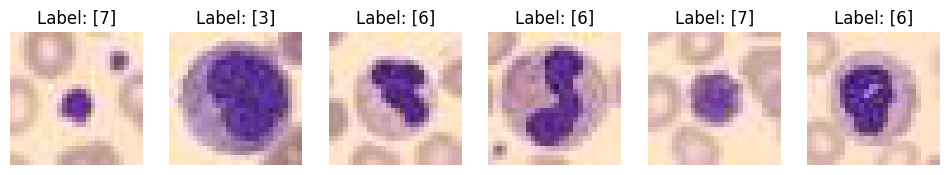

In [8]:
# Function to plot sample images
def show_samples(dataset, num_samples=6):
    fig, axes = plt.subplots(1, num_samples, figsize=(12, 4))

    for i in range(num_samples):
        img, label = dataset[i]

        # Convert PIL image to NumPy array
        img = np.array(img)  # Fix: Convert PIL image to NumPy array

        axes[i].imshow(img)  # No need for cmap="gray" since it's RGB
        axes[i].set_title(f"Label: {label}")
        axes[i].axis("off")

    plt.show()

# Show sample images from training dataset
show_samples(train_dataset)


In [9]:
# Get a single sample
sample_image, sample_label = train_dataset[0]

# Convert PIL image to NumPy array
sample_image_np = np.array(sample_image)

# Print shape and type
print(f"Image shape: {sample_image_np.shape}")
print(f"Image data type: {sample_image_np.dtype}")
print(f"Label: {sample_label}")
print(f"Label data type: {type(sample_label)}")



Image shape: (28, 28, 3)
Image data type: uint8
Label: [7]
Label data type: <class 'numpy.ndarray'>


### Class Distribution Analysis

Before applying any augmentation or training, we examine the class distribution of the BloodMNIST training dataset. As shown in the plot below, the dataset exhibits a clear **class imbalance** — some classes (e.g., Class 1 and Class 6) are significantly overrepresented, while others (e.g., Class 0 and Class 4) have much fewer samples.

This imbalance can negatively affect the learning process by biasing the model toward majority classes. To mitigate this, we later apply:
- **Offline data augmentation** (for increasing sample diversity), and
- **Class weighting** during training (to reduce bias in loss computation)

Understanding the dataset's imbalance is crucial for explaining certain model decisions and evaluating classification performance more fairly (e.g., using macro F1-score).


Class Distribution in Training Set:
Class 7: 1643 samples
Class 3: 2026 samples
Class 6: 2330 samples
Class 2: 1085 samples
Class 1: 2181 samples
Class 5: 993 samples
Class 0: 852 samples
Class 4: 849 samples


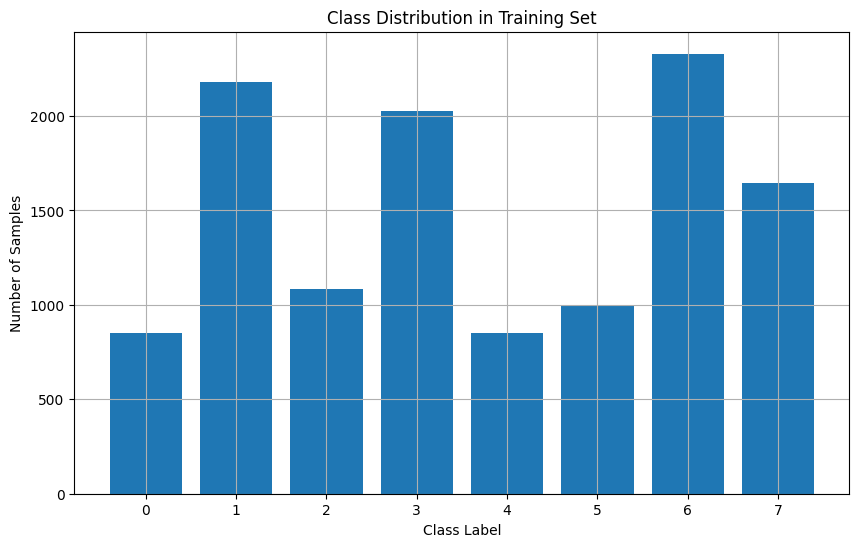

In [10]:
import collections

# Get all labels from the dataset (ensure it's a 1D array)
all_labels = np.array([train_dataset[i][1] for i in range(len(train_dataset))]).flatten()

# Count occurrences
class_counts = collections.Counter(all_labels)

# Print class counts
print("Class Distribution in Training Set:")
for label, count in class_counts.items():
    print(f"Class {label}: {count} samples")

# Plot class distribution

plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in Training Set")
plt.show()



## 3. Data Augmentation

To improve model generalization and reduce overfitting, we apply **offline data augmentation** techniques to the training dataset. Augmentation is particularly important for BloodMNIST due to the **class imbalance** and relatively small number of samples per class.

The following transformations are applied:
- Random horizontal and vertical flips
- Random rotations (up to 15 degrees)
- Zooming in and out (±10%)
- Width and height shifts (±10%)

These transformations are applied using `ImageDataGenerator` and produce new synthetic training examples while preserving class labels. The final augmented training dataset is larger than the original and more diverse in appearance.


In [11]:
# Extract images and labels from train_dataset
X_train = np.array([np.array(train_dataset[i][0]) for i in range(len(train_dataset))]) / 255.0
y_train = np.array([train_dataset[i][1] for i in range(len(train_dataset))]).flatten()

# Print shape to verify
print(f"X_train shape: {X_train.shape}")  # Expected: (num_samples, height, width, channels)
print(f"y_train shape: {y_train.shape}")  # Expected: (num_samples,)
print(f"Sample label: {y_train[0]}")


X_train shape: (11959, 28, 28, 3)
y_train shape: (11959,)
Sample label: 7


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define augmentation strategy
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Function to augment only selected classes
def augment_images(images, labels, target_classes, augment_factor=2):
    augmented_images, augmented_labels = [], []

    for img, label in zip(images, labels):
        if label in target_classes:
            img = np.expand_dims(img, axis=0)  # Expand dims for augmentation
            for _ in range(augment_factor):
                aug_img = datagen.flow(img, batch_size=1)[0]  # Generate augmented image
                augmented_images.append(aug_img.squeeze())  # Convert back
                augmented_labels.append(label)

    return np.array(augmented_images), np.array(augmented_labels)

# Define underrepresented classes
target_classes = [0, 2, 4, 5]
augment_factor = 2  # Double dataset size for these classes

# Apply augmentation
augmented_images, augmented_labels = augment_images(X_train, y_train, target_classes, augment_factor)

# Merge original dataset with augmented images
X_train_augmented = np.concatenate((X_train, augmented_images), axis=0)
y_train_augmented = np.concatenate((y_train, augmented_labels), axis=0)

print(f"New training set size after augmentation: {len(X_train_augmented)}")


New training set size after augmentation: 19517


### Computing Class Weights

Even with data augmentation, class imbalance remains an issue — especially for rare classes that still have fewer total samples. To further address this, we compute **class weights** that will be used during model training.

These weights are inversely proportional to class frequencies and help **penalize misclassifications of underrepresented classes more heavily** during loss computation. This ensures that the model doesn't simply favor the majority classes to improve accuracy.

We use `sklearn.utils.class_weight.compute_class_weight` to automatically generate balanced weights based on the distribution of the (augmented) training labels.


In [13]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_augmented),
    y=y_train_augmented
)

# Convert to dictionary format for TensorFlow
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Class Weights:", class_weight_dict)


Class Weights: {0: 0.9544698748043818, 1: 1.118580926180651, 2: 0.7495007680491551, 3: 1.2041584402764067, 4: 0.957842559874362, 5: 0.8189409197717354, 6: 1.047049356223176, 7: 1.4848600121728546}


### Dataset Conversion and Resizing for Training

With the class weights computed, we now prepare the datasets for model training and evaluation. This includes:

- Extracting and normalizing the validation and test sets
- Converting all datasets into `tf.data.Dataset` format
- Resizing all images to 64×64 pixels to match the input expected by the AE-CNN architecture

Using TensorFlow’s `Dataset` API allows efficient batching, shuffling, and prefetching. These transformations ensure that the model receives data in the correct format while maintaining high GPU throughput during training.


In [7]:
# Load validation and test datasets
X_val = np.array([np.array(val_dataset[i][0]) for i in range(len(val_dataset))]) / 255.0
y_val = np.array([val_dataset[i][1] for i in range(len(val_dataset))]).flatten()

X_test = np.array([np.array(test_dataset[i][0]) for i in range(len(test_dataset))]) / 255.0
y_test = np.array([test_dataset[i][1] for i in range(len(test_dataset))]).flatten()

# Print dataset shapes
print(f"Validation dataset shape: {X_val.shape}, Labels shape: {y_val.shape}")
print(f"Test dataset shape: {X_test.shape}, Labels shape: {y_test.shape}")


Validation dataset shape: (1712, 28, 28, 3), Labels shape: (1712,)
Test dataset shape: (3421, 28, 28, 3), Labels shape: (3421,)


In [8]:
# Convert augmented dataset to TensorFlow Dataset
train_ds_augmented = tf.data.Dataset.from_tensor_slices((X_train_augmented, y_train_augmented))
train_ds_augmented = train_ds_augmented.shuffle(len(X_train_augmented)).batch(32).prefetch(tf.data.AUTOTUNE)

# Convert validation and test datasets (without augmentation)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32).prefetch(tf.data.AUTOTUNE)


In [9]:
X_train_resized = tf.image.resize(X_train_augmented, [64, 64])

X_val_resized = tf.image.resize(X_val, [64, 64])
X_test_resized = tf.image.resize(X_test, [64, 64])

In [13]:
X_train_resized = X_train_resized.numpy()
X_val_resized = X_val_resized.numpy()
X_test_resized = X_test_resized.numpy()


In [18]:
train_ds_augmented = tf.data.Dataset.from_tensor_slices((X_train_resized, y_train_augmented))
train_ds_augmented = train_ds_augmented.shuffle(len(X_train_resized)).batch(32).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val_resized, y_val)).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test_resized, y_test)).batch(32).prefetch(tf.data.AUTOTUNE)


## 4. AE-CNN Model Architecture

We now define the architecture of the Attention-Enhanced Convolutional Neural Network (AE-CNN). The model consists of three convolutional blocks followed by a bottleneck-style channel attention module inspired by the Squeeze-and-Excitation (SE) block. This mechanism helps the model focus on the most informative feature maps.

After the attention mechanism, we apply a final convolutional layer and global average pooling, followed by a fully connected classification head. The model outputs class probabilities for all eight blood cell types using a softmax activation.

The architecture is implemented using the Keras Functional API for clarity and flexibility. Below is the full model definition:


In [19]:
from tensorflow.keras import layers, models, optimizers

def build_final_model():
    inputs = layers.Input(shape=(64, 64, 3))

    # Convolutional Backbone
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Bottleneck Attention
    gap = layers.GlobalAveragePooling2D()(x)
    squeeze = layers.Dense(32, activation='relu')(gap)
    excite = layers.Dense(128, activation='sigmoid')(squeeze)
    attn = layers.Reshape((1, 1, 128))(excite)
    x = layers.Multiply()([x, attn])

    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)

    # Fully Connected Head
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(8, activation='softmax')(x)

    model = models.Model(inputs, outputs)

    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


model = build_final_model()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 16,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 8, 8, 128) │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ max_pooling2d_2[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      4,128 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │      4,224 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 128) │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 8, 8, 128) │          0 │ max_pooling2d_2[… │
│                     │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 256) │    295,168 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ conv2d_3[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     32,896 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 8)         │      1,032 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 430,696 (1.64 MB)

 Trainable params: 430,696 (1.64 MB)

 Non-trainable params: 0 (0.00 B)

### Model Summary and Parameter Count

The printed summary shows the layer-by-layer structure of the AE-CNN model. It includes:

- Three convolutional blocks for spatial feature extraction
- A bottleneck channel attention mechanism (Squeeze-and-Excitation block)
- A final convolutional layer followed by global average pooling
- A fully connected classification head with dropout and softmax output

The model contains approximately 430,696. This compact size (~5 MB on disk) allows the model to be trained efficiently and makes it suitable for potential deployment in resource-limited environments.


## 5. Model Training

With the AE-CNN model defined, we proceed to train it using the prepared and augmented training dataset. The training configuration includes:

- **Optimizer**: Adam with a learning rate of 0.001  
- **Loss Function**: Sparse categorical cross-entropy (appropriate for integer labels in multi-class classification)  
- **Metrics**: Accuracy  
- **Batch Size**: 32  
- **Epochs**: Up to 30  
- **Early Stopping**: Stops training if validation loss does not improve for 5 consecutive epochs  
- **Class Weights**: Used to mitigate class imbalance by increasing loss impact for underrepresented classes

The training process is monitored on both training and validation datasets, and the model with the lowest validation loss is restored for final evaluation.


In [20]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_ds_augmented,                 # augmented training dataset
    validation_data=val_ds,            #  validation dataset
    epochs=30,                          # Full training
    batch_size=32,                     # Confirmed batch size
    callbacks=[early_stop],
    class_weight=class_weight_dict     # Optional class weighting
)


Epoch 1/30
610/610 ━━━━━━━━━━━━━━━━━━━━ 161s 258ms/step - accuracy: 0.2615 - loss: 1.7353 - val_accuracy: 0.5222 - val_loss: 1.2560
Epoch 2/30
610/610 ━━━━━━━━━━━━━━━━━━━━ 188s 236ms/step - accuracy: 0.4352 - loss: 1.3095 - val_accuracy: 0.4714 - val_loss: 1.3173
Epoch 3/30
610/610 ━━━━━━━━━━━━━━━━━━━━ 201s 235ms/step - accuracy: 0.5495 - loss: 1.1023 - val_accuracy: 0.7126 - val_loss: 0.7106
Epoch 4/30
610/610 ━━━━━━━━━━━━━━━━━━━━ 198s 228ms/step - accuracy: 0.6182 - loss: 0.9111 - val_accuracy: 0.7366 - val_loss: 0.6574
Epoch 5/30
610/610 ━━━━━━━━━━━━━━━━━━━━ 140s 224ms/step - accuracy: 0.6616 - loss: 0.8293 - val_accuracy: 0.7646 - val_loss: 0.5918
Epoch 6/30
610/610 ━━━━━━━━━━━━━━━━━━━━ 139s 227ms/step - accuracy: 0.7124 - loss: 0.7237 - val_accuracy: 0.8213 - val_loss: 0.4884
Epoch 7/30
610/610 ━━━━━━━━━━━━━━━━━━━━ 154s 247ms/step - accuracy: 0.7692 - loss: 0.6204 - val_accuracy: 0.8394 - val_loss: 0.4479
Epoch 8/30
610/610 ━━━━━━━━━━━━━━━━━━━━ 196s 238ms/step - accuracy: 0.7838 -

In [21]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")


107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.9400 - loss: 0.1675
🧪 Test Accuracy: 0.9427, Test Loss: 0.1716


## 6. Evaluation and Training Curve Analysis

After training, the model was evaluated on the test set, achieving a final **test accuracy of 94.3%** and a **test loss of 0.17**. These results confirm that the AE-CNN model generalizes well to unseen data.

The training curves plotted below illustrate a smooth and consistent improvement over time:
- **Accuracy** steadily increases for both training and validation sets, with minimal gap, indicating low overfitting.
- **Loss** decreases significantly, with validation loss flattening around epoch 20, aligning with early stopping behavior.

The close alignment between training and validation metrics suggests that the model was effectively regularized using dropout, augmentation, and class weights.


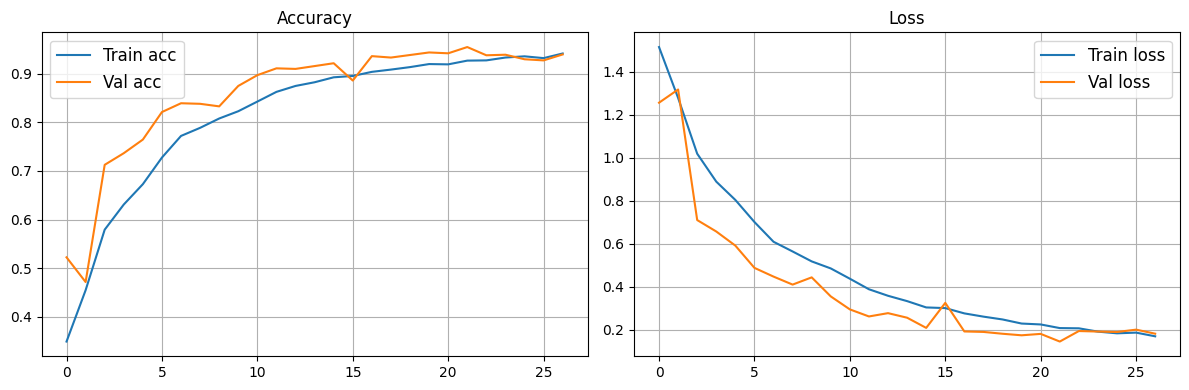

In [22]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [24]:
model.save('cnn_bottleneck_attention_final.keras')


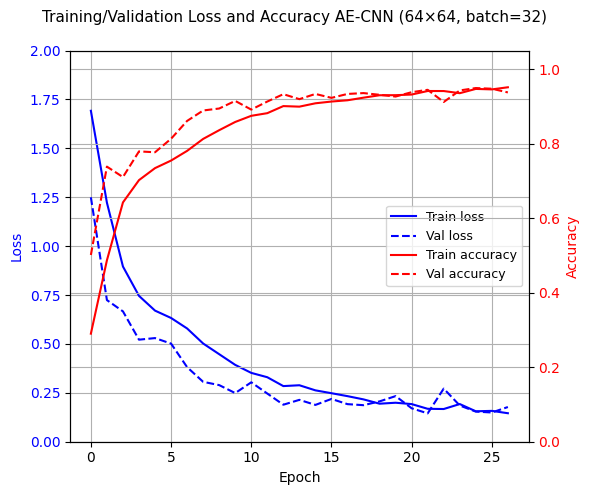

In [37]:
# Load our training log
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/manual_training_log.csv')

fig, ax1 = plt.subplots(figsize=(6, 5))

# Left y-axis: Loss
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='blue')
ax1.plot(df['loss'], label='Train loss', color='blue', linestyle='-')
ax1.plot(df['val_loss'], label='Val loss', color='blue', linestyle='--')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0, 2.0)

# Right y-axis: Accuracy
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='red')
ax2.plot(df['accuracy'], label='Train accuracy', color='red', linestyle='-')
ax2.plot(df['val_accuracy'], label='Val accuracy', color='red', linestyle='--')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 1.05)

# Title
fig.suptitle('Training/Validation Loss and Accuracy AE-CNN (64×64, batch=32)', fontsize=11)

# Combine legends and place inside at middle right
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right', fontsize=9)

plt.tight_layout()
plt.savefig('ae_cnn_final_loss_accuracy_center_right.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Confusion Matrix, ROC Curves, and Model Summary

To further evaluate the per-class performance of the AE-CNN model, we generate the **confusion matrix** on the test set. Most classes are predicted with high accuracy, with only minor misclassifications between similar cell types.

In addition, we compute **per-class ROC curves** to assess the model’s discriminative ability across all eight classes. The AE-CNN achieves **AUC = 1.00** for seven classes and **AUC = 0.99** for one underrepresented class, confirming strong separability.

Finally, we measure the total model size and training time:
- **Model size**: 5.00 MB (saved in `.keras` format)
- **Average training time**: ~180 seconds per epoch, ~90 minutes total

These results demonstrate that the AE-CNN achieves high classification performance with relatively low computational cost, making it suitable for practical deployment.


In [25]:
model.save('cnn_bottleneck_attention_final.keras')

In [6]:
model_path = 'cnn_bottleneck_attention_final.keras'
model = keras.models.load_model(model_path)

# check size
import os
model_size_MB = os.path.getsize(model_path) / (1024 * 1024)
print(f"Model size: {model_size_MB:.2f} MB")


Model size: 5.00 MB


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 18 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [26]:
from tensorflow.keras.models import load_model
model = load_model('cnn_bottleneck_attention_final.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 18 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━

,precision,recall,f1-score,support
0,0.839844,0.881148,0.860000,244.000000
1,0.998374,0.983974,0.991122,624.000000
2,0.973154,0.932476,0.952381,311.000000
3,0.850993,0.887737,0.868977,579.000000
4,0.925197,0.967078,0.945674,243.000000
5,0.925373,0.873239,0.898551,284.000000
6,0.974281,0.966967,0.970610,666.000000
7,1.000000,0.989362,0.994652,470.000000
accuracy,0.942707,0.942707,0.942707,0.942707
macro avg,0.935902,0.935248,0.935246,3421.000000


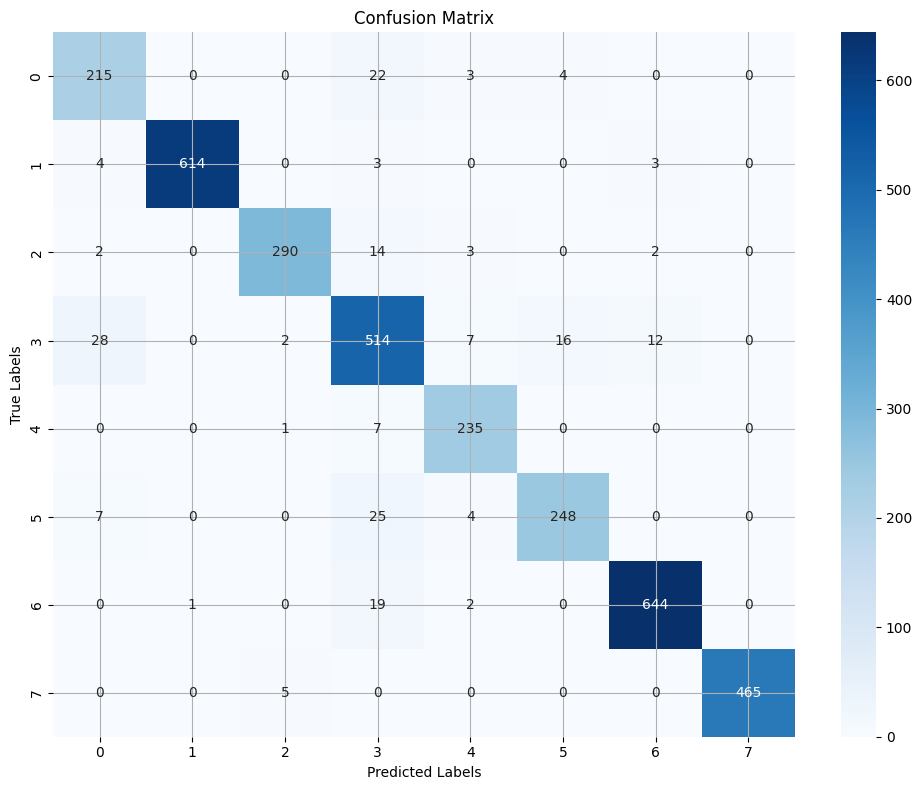

In [27]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

test_ds = tf.data.Dataset.from_tensor_slices((X_test_resized, y_test)).batch(32).prefetch(tf.data.AUTOTUNE)

# Get true and predicted labels
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification Report
report = classification_report(y_true, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
display(report_df)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━

<ipython-input-12-871763209>:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_classes)


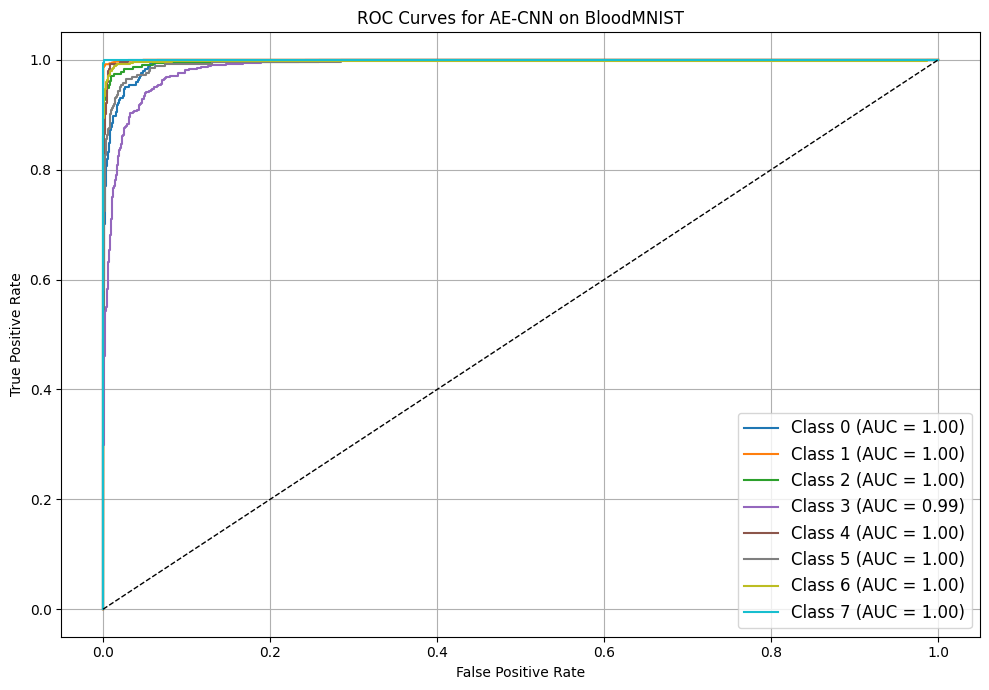

In [12]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Get model predictions
y_true = []
y_score = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_score.extend(preds)
    y_true.extend(labels.numpy())

y_score = np.array(y_score)
y_true = np.array(y_true)

# Binarize labels for ROC
n_classes = y_score.shape[1]
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

# Compute ROC and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 7))
colors = plt.cm.get_cmap('tab10', n_classes)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})', color=colors(i))

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.title('ROC Curves for AE-CNN on BloodMNIST')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig("ae_cnn_roc_curves.png", dpi=300)
plt.show()


##  Results Summary

The AE-CNN model was evaluated across multiple performance dimensions. The key results are summarized below:

- **Test Accuracy**: 94.3%
- **Test Loss**: 0.17
- **Macro F1 Score**: 0.935
- **Model Size**: 5.00 MB
- **Training Time**: ~90 minutes (30 epochs, early stopping enabled)
- **Batch Size**: 32
- **Learning Rate**: 0.001

**Per-Class Evaluation**:
- Confusion matrix shows strong classification accuracy across all 8 blood cell types
- ROC curves demonstrate excellent class separability:
  - AUC = 1.00 for 7 classes
  - AUC = 0.99 for 1 class

Overall, the AE-CNN architecture proves to be a compact and effective solution for multiclass blood cell classification, balancing accuracy, efficiency, and simplicity.
